# Adding New Anomaly Detection Models

This notebook provides a minimal example on how to add a new anomaly detection model to Merlion. We follow the instructions in [CONTRIBUTING.md](https://github.com/salesforce/Merlion/blob/main/CONTRIBUTING.md). We suggest you review this [notebook](1_AnomalyFeatures.ipynb) explaining how to use a Merlion anomaly detection model before reading this notebook.

More specifically, let's implement an anomaly detection model whose anomaly score is just equal to the value of the time series metric (after mean and variance normalization). By default, we want the model to fire an alarm when the value of the time series metric is more than 3 standard deviations away from the mean value.

Note that this is already implemented [here](https://github.com/salesforce/Merlion/blob/main/merlion/models/anomaly/stat_threshold.py) as the `StatThreshold` algorithm. For a more complete example, see our implementation of [Isolation Forest](https://github.com/salesforce/Merlion/blob/main/merlion/models/anomaly/isolation_forest.py).

## Model Config Class

The first step of creating a new model is defining an appropriate config class, which inherits from `DetectorConfig`:

In [1]:
from merlion.models.anomaly.base import DetectorConfig
from merlion.post_process.threshold import Threshold
from merlion.transform.normalize import MeanVarNormalize

class StatThresholdConfig(DetectorConfig):
    # If the transform argument is not provided when initializing the config,
    # we will pre-process the input by normalizing it to be zero mean (but
    # not unit variance!)
    _default_transform = MeanVarNormalize(normalize_scale=False)

    # When you call model.get_anomaly_label(), you will transform the model's
    # raw anomaly scores (returned by model.get_anomaly_score() into z-scores,
    # and you will apply a thresholding rule to suppress all anomaly scores
    # with magnitude smaller than the threshold. Here, we only wish to report
    # 3-sigma events.
    _default_threshold = Threshold(alm_threshold=3.0)

    def __init__(self, **kwargs):
        """
        Provide model-specific config parameters here, with kwargs to capture any
        general-purpose arguments used by the base class. For DetectorConfig,
        these are transform and post_rule.
        
        We include the initializer here for clarity. In this case, it may be
        excluded, as it only calls the superclass initializer.
        """
        super().__init__(**kwargs)

## Model Class

Next, we define the model itself, which must inherit from the `DetectorBase` base class and define all abstract methods. See the API docs for more details.

In [2]:
from merlion.evaluate.anomaly import TSADMetric
from merlion.models.anomaly.base import DetectorBase
from merlion.utils import TimeSeries


class StatThreshold(DetectorBase):
    # The config class for StatThreshold is StatThresholdConfig, defined above
    config_class = StatThresholdConfig

    # By default, we would like to train the model's post-rule (i.e. the threshold
    # at which we fire an alert) to maximize F1 score
    _default_post_rule_train_config = dict(metric=TSADMetric.F1)
    
    def __init__(self, config: StatThresholdConfig):
        """
        Sets the model config and any other local variables. We include the
        initializer here for clarity. In this case, it may be excluded, as it
        only calls the superclass initializer.
        
        :param config: model configuration
        """
        super().__init__(config)


    def train(self, train_data: TimeSeries,
              anomaly_labels: TimeSeries = None,
              train_config=None, post_rule_train_config=None) -> TimeSeries:
        # Apply standard pre-processing steps before training the model. Note
        # that this model can accept arbitrary time stamps, but it only works
        # for univariate time series, so we specify that.
        train_data = self.train_pre_process(
            train_data, require_even_sampling=False, require_univariate=True)
                
        # Since this model's anomaly scores are just the values of the time
        # series metric (after any pre-processing), there is no model to train.
        # In general, you should train your model here, and determine its
        # anomaly scores on the training data. Note that this training should not
        # use anomaly_labels in any way!
        train_data = train_data.univariates[train_data.names[0]]
        train_anom_scores = TimeSeries({"anom_score": train_data})
        
        # We train the model's post-rule here, based on the training anomaly scores
        # and the anomaly labels (if none are given, an unsupervised threshold
        # selection strategy is used).
        self.train_post_rule(train_anom_scores, anomaly_labels, post_rule_train_config)
        
        # Return the model's predicted anomaly scores on the train data
        return train_anom_scores

    def get_anomaly_score(self, time_series: TimeSeries,
                          time_series_prev: TimeSeries = None) -> TimeSeries:
        
        # Apply the data pre-processing transform on the input data.
        # Make sure to prepend time_series_prev to time_series if it is given.
        time_series, time_series_prev = self.transform_time_series(
            time_series, time_series_prev)
        
        # For this model, the anomaly scores are just the values of the time
        # time series metric. Make sure to return a time series with a single
        # variable named "anom_score".
        anom_scores = time_series.univariates[time_series.names[0]]
        return TimeSeries({"anom_score": anom_scores})

## Running the Model: A Simple Example

Let's try running this model on some actual data! This next part assumes you've installed `ts_datasets`. We'll begin by getting a time series from the NAB dataset & visualizing it.

Time series /Users/abhatnagar/Desktop/Merlion_public/data/nab/realKnownCause/ec2_request_latency_system_failure.csv (index 2) has timestamp duplicates. Kept first values.
Time series /Users/abhatnagar/Desktop/Merlion_public/data/nab/realKnownCause/machine_temperature_system_failure.csv (index 3) has timestamp duplicates. Kept first values.


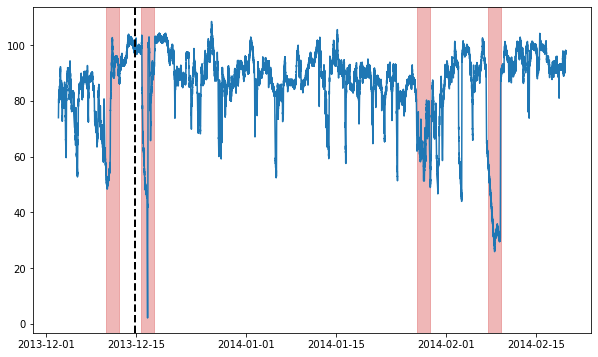

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from merlion.plot import plot_anoms
from merlion.utils import TimeSeries
from ts_datasets.anomaly import NAB

# This is a time series with anomalies in both the train and test split.
# time_series and metadata are both time-indexed pandas DataFrames.
time_series, metadata = NAB(subset="realKnownCause")[3]

# Visualize the full time series
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)

# Label the train/test split with a dashed line & plot anomalies
ax.axvline(metadata[metadata.trainval].index[-1], ls="--", lw=2, c="k")
plot_anoms(ax, TimeSeries.from_pd(metadata.anomaly))

Now, we'll split the data into train & test splits, and run our anomaly detection model on it.

In [4]:
# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

In [5]:
# Initialize a model & train it. The dataframe returned & printed
# below is the model's anomaly scores on the training data.
model = StatThreshold(StatThresholdConfig())
model.train(train_data=train_data, anomaly_labels=train_labels)

                     anom_score
2013-12-02 21:15:00   -9.065700
2013-12-02 21:20:00   -8.097140
2013-12-02 21:25:00   -6.908860
2013-12-02 21:30:00   -4.892315
2013-12-02 21:35:00   -3.703186
...                         ...
2013-12-14 16:25:00   15.041999
2013-12-14 16:30:00   14.494303
2013-12-14 16:35:00   16.234568
2013-12-14 16:40:00   15.160902
2013-12-14 16:45:00   15.055357

[3403 rows x 1 columns]

In [6]:
# Let's run the our model on the test data, both with and without
# applying the post-rule. Notice that applying the post-rule filters out
# a lot of entries!
import pandas as pd
anom_scores = model.get_anomaly_score(test_data).to_pd()
anom_labels = model.get_anomaly_label(test_data).to_pd()
print(pd.DataFrame({"no post rule": anom_scores.iloc[:, 0],
                    "with post rule": anom_labels.iloc[:, 0]}))

                     no post rule  with post rule
2013-12-14 16:50:00     14.520900             0.0
2013-12-14 16:55:00     15.065935             0.0
2013-12-14 17:00:00     15.825172             0.0
2013-12-14 17:05:00     13.846644             0.0
2013-12-14 17:10:00     15.050966             0.0
...                           ...             ...
2014-02-19 15:05:00     15.152393             0.0
2014-02-19 15:10:00     14.771146             0.0
2014-02-19 15:15:00     14.102446             0.0
2014-02-19 15:20:00     15.023830             0.0
2014-02-19 15:25:00     13.870839             0.0

[19280 rows x 2 columns]


In [7]:
# Additionally, notice that the nonzero post-processed anomaly scores,
# are interpretable as z-scores. This is due to the automatic calibration.
print(anom_labels[anom_labels.iloc[:, 0] != 0])

                     anom_score
2013-12-16 06:40:00   -3.024196
2013-12-16 06:45:00   -3.012073
2013-12-16 07:00:00   -3.468464
2013-12-16 07:05:00   -3.124039
2013-12-16 07:10:00   -3.491421
...                         ...
2014-02-09 11:35:00   -4.819248
2014-02-09 11:40:00   -4.823173
2014-02-09 11:45:00   -4.822201
2014-02-09 11:50:00   -4.677379
2014-02-09 11:55:00   -4.300280

[721 rows x 1 columns]


## Visualization

Qualitatively, we can plot the anomaly score sequences to see the difference.

no post rule


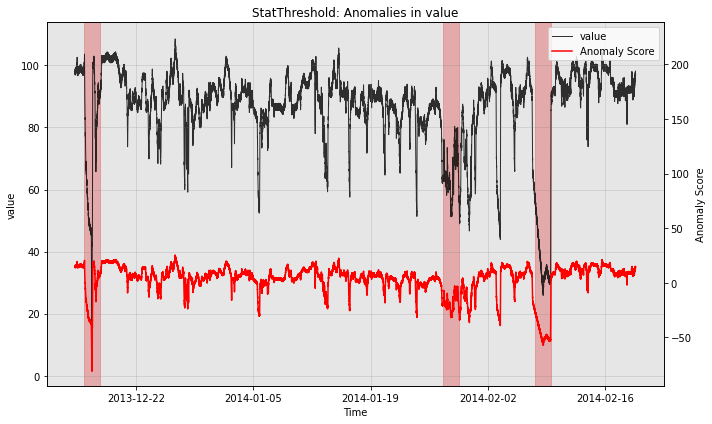

In [8]:
print("no post rule")
fig, ax = model.plot_anomaly(test_data, filter_scores=False)
plot_anoms(ax, test_labels)
plt.show()

with post rule


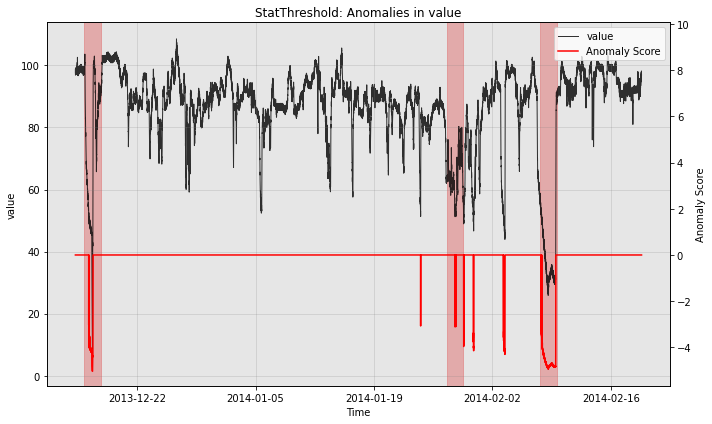

In [9]:
print("with post rule")
fig, ax = model.plot_anomaly(test_data, filter_scores=True)
plot_anoms(ax, test_labels)
plt.show()

## Customizing the Post-Rule

The example above uses a simple threshold as the post-processing rule. As a result, the model is continuously firing alerts when the differenced time series value is far from 0. We support an alternative option which combines successive alerts into a single alert. We demonstrate this below.

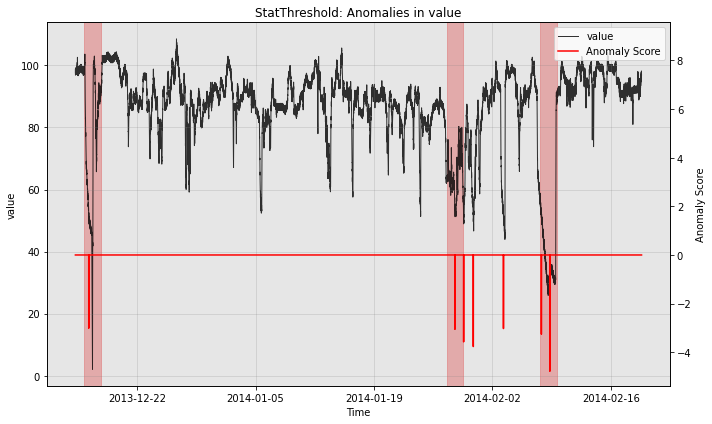

In [10]:
from merlion.post_process.threshold import AggregateAlarms

# We use a custom post-rule (AggegateAlarms instead of the default Threshold),
# where we suppress all alarms for a day after the most recent one is fired.
threshold = AggregateAlarms(alm_threshold=3.0, alm_suppress_minutes=24*60)
model2 = StatThreshold(StatThresholdConfig(threshold=threshold))

# Train the model as before
model2.train(train_data, train_labels)

# Visualize the model's anomaly scores with the new post-rule
fig, ax = model2.plot_anomaly(test_data, filter_scores=True)
plot_anoms(ax, test_labels)
plt.show()

## Quantitative Evaluation

Finally, you may quantitatively evaluate the performance of your model as well. Here, we compute precision, recall, and F1 score for `model2` above.

In [11]:
anom_labels2 = model2.get_anomaly_label(test_data)

print("Model Evaluation")
print(f"Precision: {TSADMetric.Precision.value(ground_truth=test_labels, predict=anom_labels2):.4f}")
print(f"Recall:    {TSADMetric.Recall.value(ground_truth=test_labels, predict=anom_labels2):.4f}")
print(f"F1 Score:  {TSADMetric.F1.value(ground_truth=test_labels, predict=anom_labels2):.4f}")

Model Evaluation
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.6667
